<a href="https://colab.research.google.com/github/alonsodiaxz/TensorFlowExamples/blob/main/RecImg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [6]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True) #Los dos atributos son importantes para obtener los metadatos

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMF1WW8/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMF1WW8/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [8]:
datos

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [9]:
#Pongamos cada conjunto de datos en variables distintas, para tener separados los datos de entrenamiento y los datos de testeo.
datos_entrenamiento, datos_pruebas= datos['train'], datos['test']

In [10]:
datos_entrenamiento


<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
nombre_clases = metadatos.features['label'].names

In [12]:
nombre_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
#Normalizar los datos, es decir, darle valores numéricos a todas las entradas (0-1) ya que ayuda mucho a acelerar el entrenamiento y mejorar los resultados.
#Para ello, utilizaremos la siguiente función.
def normalizar(imagenes, etiquetas):
 imagenes = tf.cast(imagenes, tf.float32)
 imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
 return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregaremos los datos a  cache (usar memoria en lugar de disco, entrenamiento más rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas= datos_pruebas.cache()


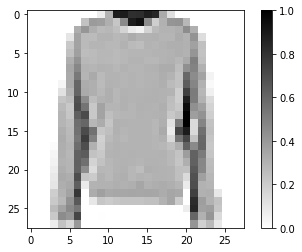

In [14]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


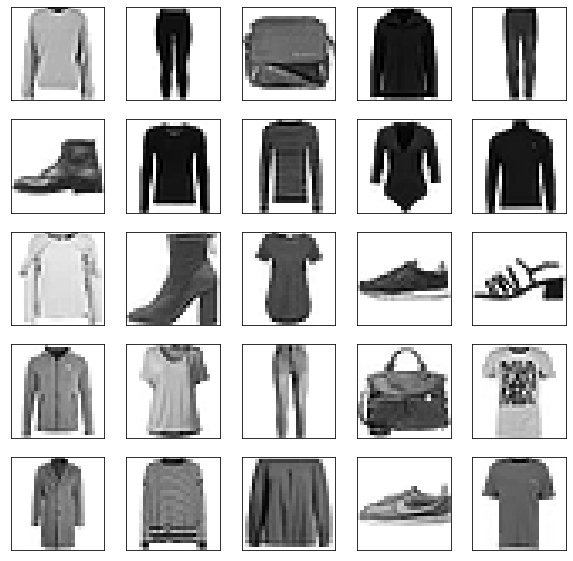

In [19]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])

plt.show()

In [31]:
#Capas del modelo
entrada = tf.keras.layers.Flatten(input_shape=(28,28,1)) #1 - blanco y negro. Flat comprime toda la matriz en una sola dimension con 784 neuronas (28x28).
oculta1 = tf.keras.layers.Dense(units=50, activation=tf.nn.relu) #La funcion relu elimina los valores negativos dejandolos como 0 y dejando los positivos.
oculta2 = tf.keras.layers.Dense(units=50, activation=tf.nn.relu )
salida = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax) #Para redes de clasificacion en la capa de salida, 
#ya que asegura que las suma de las neuronas de salida sea 1.

#Crear modelo
modelo= tf.keras.Sequential([entrada, oculta1, oculta2, salida])

In [34]:
#Compilar el modelo

modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [35]:
#Como tenemos un gran volumen de datos, para agilizarlo vamos a compilarlo por lotes de 32
TAMANO_LOTE = 32
#Lo realizaremos de manera alelatoria
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)


In [36]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5 ,steps_per_epoch=math.ceil(60000/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 12s 3ms/step - loss: 0.5192 - accuracy: 0.8159
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3813 - accuracy: 0.8627
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3534 - accuracy: 0.8714
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3358 - accuracy: 0.8755
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3088 - accuracy: 0.8866


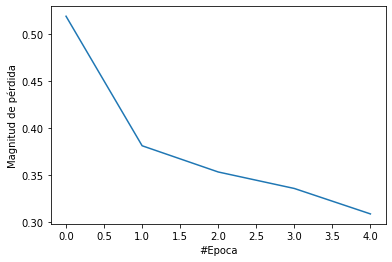

In [37]:

plt.xlabel("#Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

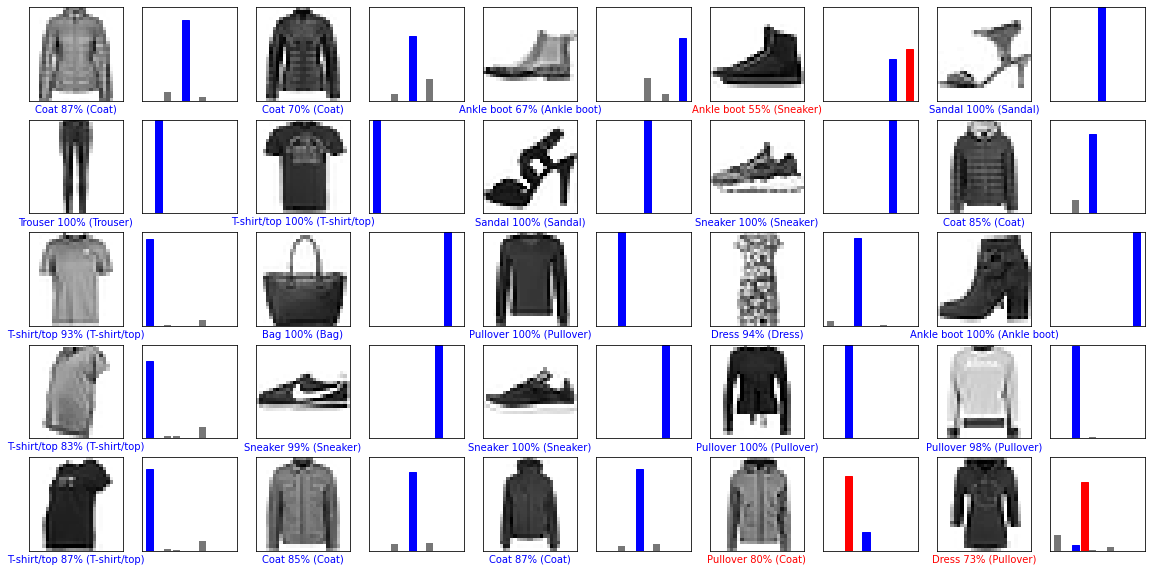

In [39]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombre_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombre_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)